# Data Exploration

Preprocessing steps which we could take:

- Remove/check 'R_A' , 'R_V' and 'R' from `ACTIVITY_TYPE`. Very few occurences, not sure what they represent (maybe ask first).
- Remove 'NB', 'VB' and 'VST' from `TRAINSERIE_DIRECTION`. Same story as above.
- Remove 'MS' from `ROLLINGSTOCK_TYPE`,  NS people said this train was not relevant.
- Change `SPLIT` and `COMBINE` to a binary value.
- Give `ROLLINGSTOCK_TYPE` and `STATION` categorical labels. Not required for all ML models I guess
- Remove rows where `TURNOVER_TIME` is larger than 1 hour or shorter than a minute.
- Remove rows where `DEPARTURE_SIGNAL_SHOW_SAFE` is larger than `PLAN_DATETIME`. From last meeting, to ensure that trunover times are not inflated by holdups on the track.
- Remove rows where `DELAY` is larger than x or smaller than x.
- Normalize numerical values: `DELAY` 

In [1]:
from time import time
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from utils import preprocessing as prep


In [2]:
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

## 1. Load Data

Load the full dataset:

In [3]:
df_full = pd.read_csv('Data.csv', low_memory = False) # Only for comparison and visualisation

In [4]:
df = prep.set_types(df_full)

In [5]:
turnover_df = prep.calc_turnover(df)

C:\Users\Gebruiker\Documents\CODE\Master\Thesis\utils\preprocessing.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["PLAN_TURNOVER_TIME"] = plan_turnover_time
C:\Users\Gebruiker\Documents\CODE\Master\Thesis\utils\preprocessing.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan["REALIZED_TURNOVER_TIME"] = real_turnover_time
C:\Users\Gebruiker\Documents\CODE\Master\Thesis\utils\preprocessing.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [6]:
turnover_df["PLAN_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["PLAN_DATETIME"]).dt.total_seconds()
turnover_df["REALIZED_SIGNAL_SAFE_DELAY"] = (turnover_df["DEPARTURE_SIGNAL_SHOWS_SAFE"] - turnover_df["REALIZED_DATETIME"]).dt.total_seconds()

Transform `COMBINE`and `SPLIT` into binary values, removing NaN values in the proces:

In [7]:
turnover_df['COMBINE'] = turnover_df['COMBINE'].notna().astype(int)
df_full['COMBINE'] = df_full['COMBINE'].notna().astype(int)

turnover_df['SPLIT'] = turnover_df['SPLIT'].notna().astype(int)
df_full['SPLIT'] = df_full['SPLIT'].notna().astype(int)


In [8]:
turnover_df = turnover_df[(turnover_df["PLAN_TURNOVER_TIME"] >= 30) & (turnover_df["PLAN_TURNOVER_TIME"] <= 6000)]
turnover_df = turnover_df[(turnover_df["DELAY"] >= -600) & (turnover_df["DELAY"] <= 10000)]

## 2. Data Exploration

Text(0, 0.5, 'Delay (seconds)')

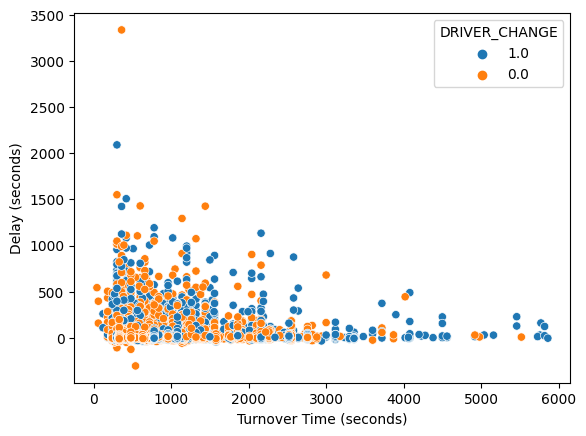

In [9]:
fig = sns.scatterplot(turnover_df, x="PLAN_TURNOVER_TIME", y="DELAY", hue = "DRIVER_CHANGE")

fig.get_xaxis().set_label_text('Turnover Time (seconds)')
fig.get_yaxis().set_label_text('Delay (seconds)')

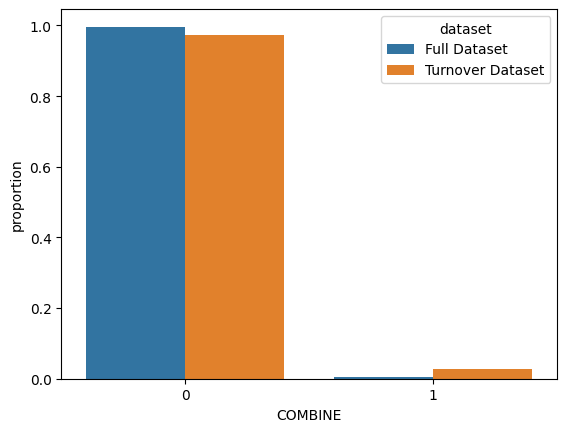

In [10]:
# Calculate proportions for the full dataset
full_counts = df_full['COMBINE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['COMBINE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['COMBINE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['COMBINE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(combined_data, x='COMBINE',y = 'proportion', hue = "dataset")
plt.show()

<Axes: xlabel='SPLIT', ylabel='proportion'>

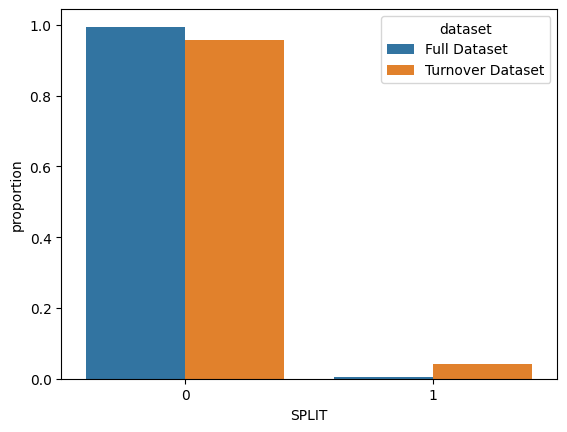

In [11]:
# Calculate proportions for the full dataset
full_counts = df_full['SPLIT'].value_counts(normalize=True).reset_index()
full_counts.columns = ['SPLIT', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['SPLIT'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['SPLIT', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'


# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])
sns.barplot(combined_data, x = "SPLIT", y = 'proportion', hue = 'dataset')

In [12]:
turnover_df = turnover_df.loc[turnover_df["PLAN_SIGNAL_SAFE_DELAY"] < 10]

<Axes: xlabel='PLAN_SIGNAL_SAFE_DELAY', ylabel='Count'>

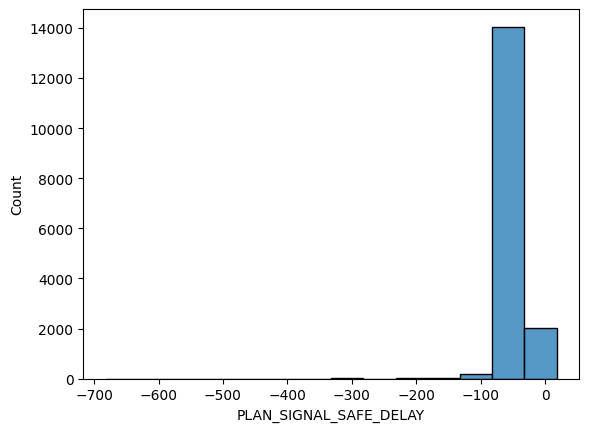

In [13]:
sns.histplot(turnover_df, x = "PLAN_SIGNAL_SAFE_DELAY", binwidth = 50)

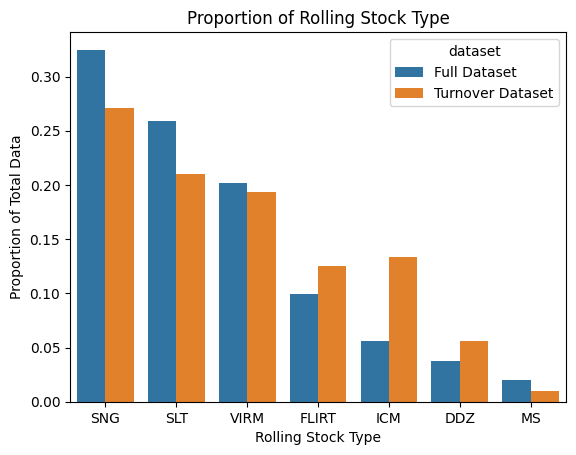

In [14]:
# Calculate proportions for the full dataset
full_counts = df_full['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['ROLLINGSTOCK_TYPE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['ROLLINGSTOCK_TYPE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['ROLLINGSTOCK_TYPE'].value_counts().index

sns.barplot(data=combined_data, x='ROLLINGSTOCK_TYPE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Rolling Stock Type')
plt.xlabel('Rolling Stock Type')
plt.ylabel('Proportion of Total Data')

plt.show()

<Axes: xlabel='PLAN_TURNOVER_TIME', ylabel='ROLLINGSTOCK_TYPE'>

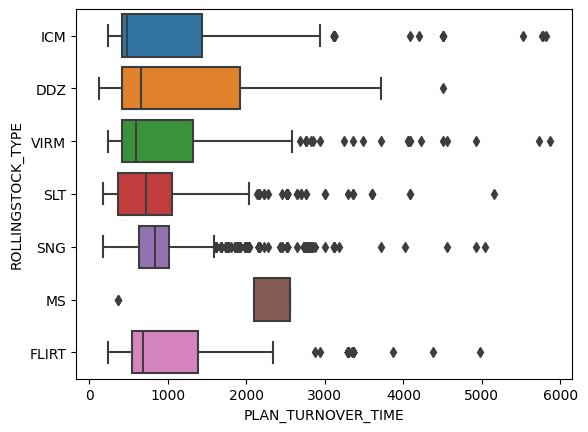

In [15]:
sns.boxplot(turnover_df, x = "PLAN_TURNOVER_TIME",y = "ROLLINGSTOCK_TYPE")

<Axes: xlabel='ACTIVITYTYPE', ylabel='count'>

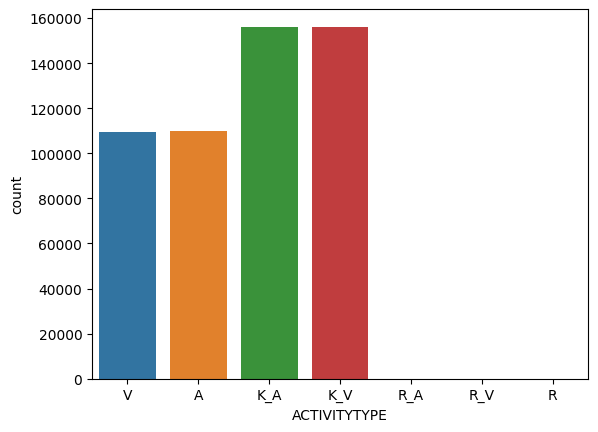

In [16]:
sns.countplot(df_full, x = "ACTIVITYTYPE")

<Axes: xlabel='TRAINSERIE_DIRECTION', ylabel='count'>

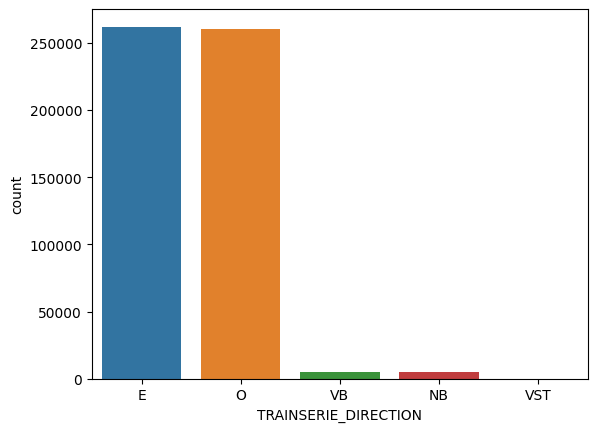

In [17]:
sns.countplot(df_full, x = "TRAINSERIE_DIRECTION")

The turnover data has 292 unique stations
The regular data has 292 unique stations


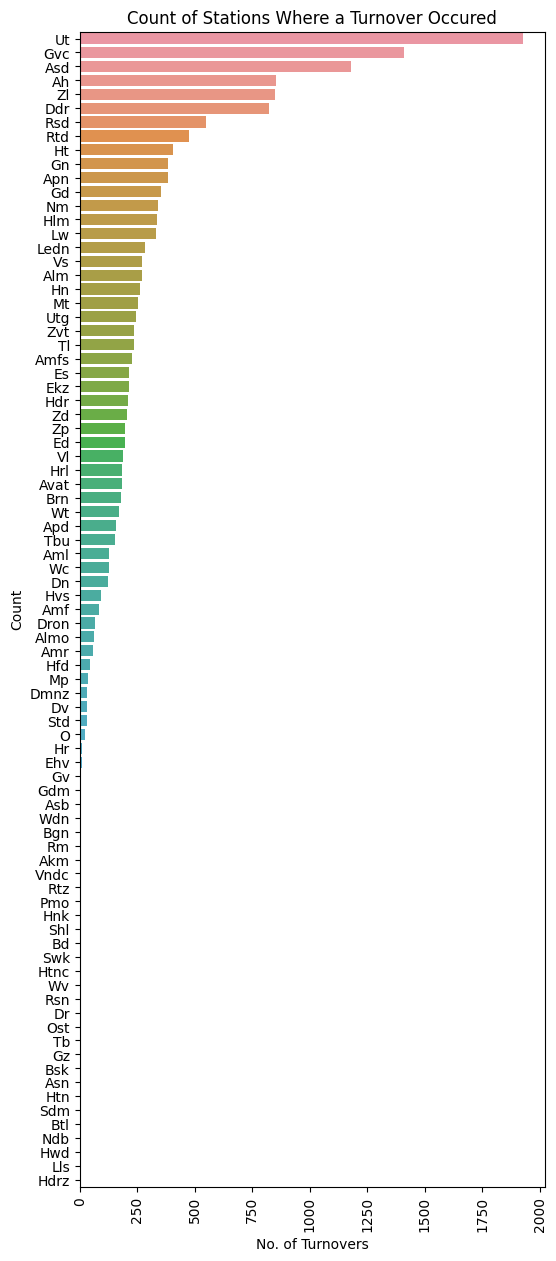

In [18]:
order = turnover_df['STATION'].value_counts().index

# Inrease the figure size
plt.figure(figsize=(6, 15))  

sns.countplot(turnover_df, y = "STATION", order=order)

plt.title('Count of Stations Where a Turnover Occured')
plt.xlabel('No. of Turnovers')
plt.ylabel('Count')

plt.xticks(rotation=90)  # Rotate labels to avoid overlap

print('The turnover data has {} unique stations'.format(len(df['STATION'].unique())))
print('The regular data has {} unique stations'.format(len(df_full['STATION'].unique())))

plt.show()

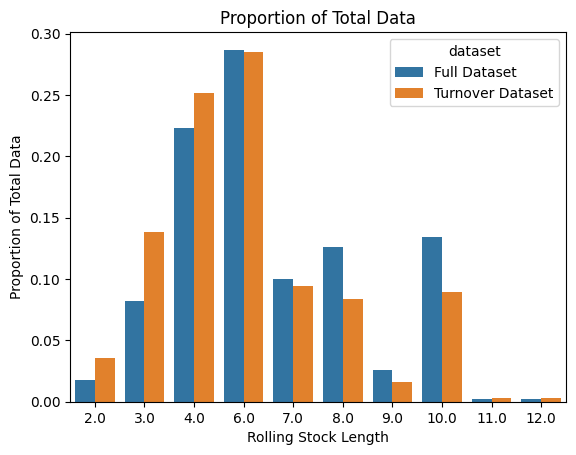

In [19]:
# Calculate proportions for the full dataset
full_counts = df_full['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
full_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['NUMBER_CARRIAGES'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['NUMBER_CARRIAGES', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

sns.barplot(data=combined_data, x='NUMBER_CARRIAGES', y='proportion', hue='dataset')

plt.title('Proportion of Total Data')
plt.xlabel('Rolling Stock Length')
plt.ylabel('Proportion of Total Data')

plt.show()

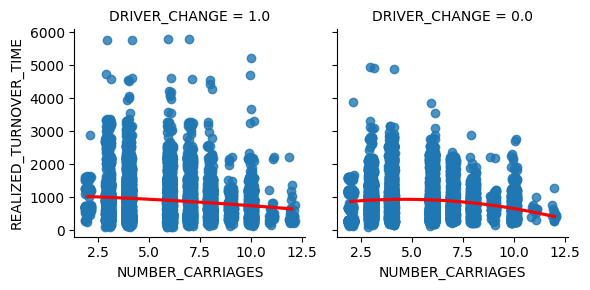

In [20]:
g = sns.FacetGrid(turnover_df, col="DRIVER_CHANGE")  

g.map(sns.regplot, "NUMBER_CARRIAGES", "REALIZED_TURNOVER_TIME", order=2, x_jitter=.15, line_kws={'color': 'red'})

plt.show()

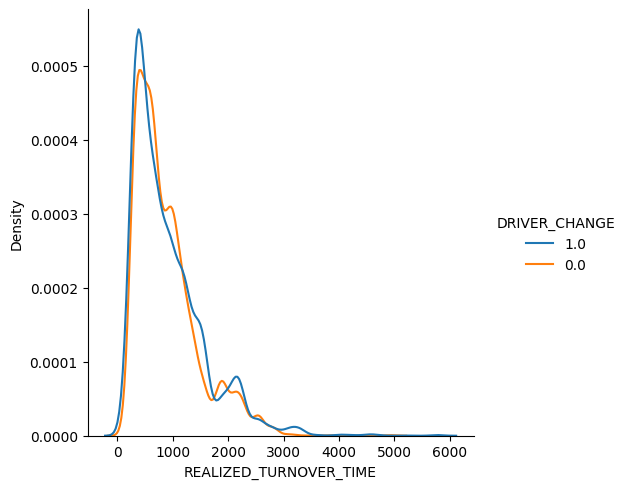

In [21]:
sns.displot(turnover_df, x = "REALIZED_TURNOVER_TIME", hue = "DRIVER_CHANGE", kind = 'kde')

Driver changes are more likely to occur when a turnover happens as well:

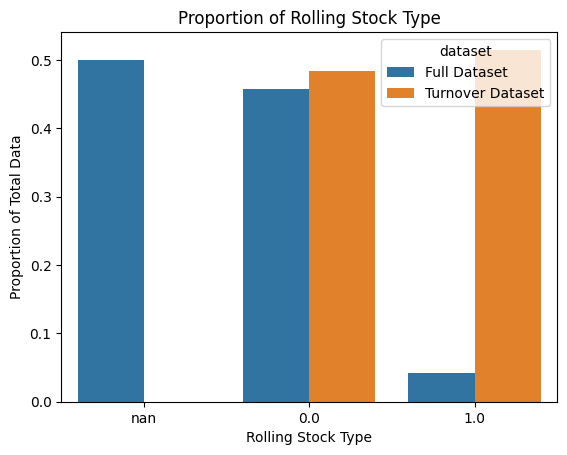

In [22]:
# Calculate proportions for the full dataset
full_counts = df_full['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
full_counts.columns = ['DRIVER_CHANGE', 'proportion']
full_counts['dataset'] = 'Full Dataset'

# Calculate proportions for the subset
turnover_counts = turnover_df['DRIVER_CHANGE'].value_counts(normalize=True).reset_index()
turnover_counts.columns = ['DRIVER_CHANGE', 'proportion']
turnover_counts['dataset'] = 'Turnover Dataset'

# Combine the two datasets
combined_data = pd.concat([full_counts, turnover_counts])

# Create a barplot to show proportions
order = df_full['DRIVER_CHANGE'].value_counts().index

sns.barplot(data=combined_data, x='DRIVER_CHANGE', y='proportion', hue='dataset', order=order)

plt.title('Proportion of Rolling Stock Type')
plt.xlabel('Rolling Stock Type')
plt.ylabel('Proportion of Total Data')

plt.show()

## 3. Linear Model

In [30]:
turnover_df["ROLLINGSTOCK_CODE"] = turnover_df["ROLLINGSTOCK_TYPE"].replace({ 'SNG': 0, 'SLT': 1, 'VIRM' : 2, 'FLIRT' : 3, 'ICM' : 4, 'DDZ' : 5, 'MS' : 6})

le = LabelEncoder()
turnover_df['STATION_CODE'] = le.fit_transform(turnover_df['STATION'])


In [32]:
# Selecting the relevant columns for the regression analysis
relevant_data = turnover_df[['ROLLINGSTOCK_CODE', 'STATION_CODE', 'SPLIT', 'COMBINE', 'NUMBER_CARRIAGES', 'DRIVER_CHANGE', 'PLAN_TURNOVER_TIME']]
X = relevant_data.drop('PLAN_TURNOVER_TIME', axis=1)
y = relevant_data['PLAN_TURNOVER_TIME']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Calculate metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])

rmse, r2, coefficients


(607.1399630960934,
 0.05438257132955304,
                    Coefficient
 ROLLINGSTOCK_CODE    33.862896
 STATION_CODE         -0.954221
 SPLIT               331.893518
 COMBINE             277.235585
 NUMBER_CARRIAGES    -24.991728
 DRIVER_CHANGE        16.142630)

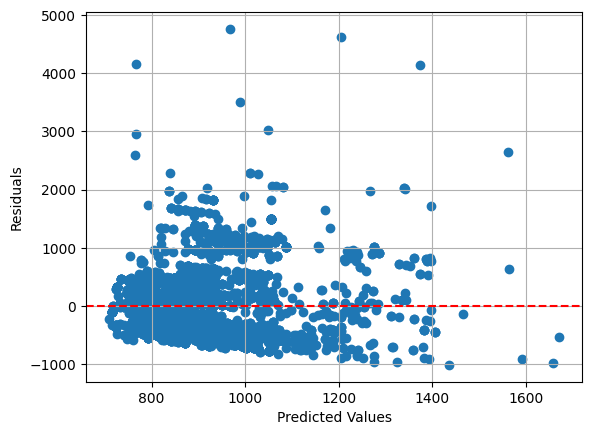

In [40]:
# Calculate residuals
residuals = y_test - y_pred

# Plotting residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True)
plt.show()